<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = ['datetime'], index_col=[0])

In [3]:
# смотрим первые 5 значений
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# проверим, расположены ли данные в хронологическом порядке
print(df.index.is_monotonic)

True


In [5]:
# общая информация
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
print('Количество пропущенных значений:', df.isna().sum().sum())

Количество пропущенных значений: 0


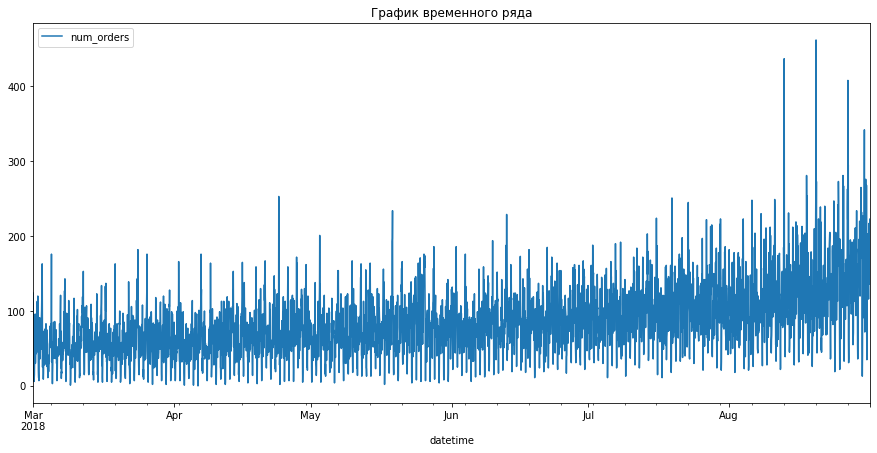

In [8]:
# ресемплирование с суммой заказов на каждый час по часам и посмотрим график:
df = df.resample('1H').sum()
df.plot(figsize=(15,7))
plt.title('График временного ряда');

В нашем распоряжении данные с 1 марта 2018 по 31 августа 2018, всего 26 496 записей. Пропущенных значений нет, тип данных корректный. Дубликаты искать бессмысленно, так как количествово заказов  может повторяться.
Данные ресемплированы по 1 часу по условию задачи.

## Анализ

Применим скользящее среднее для сглаживание исходного ряда для выявления трендов. Попробуем два сглаживания - суточное и недельное

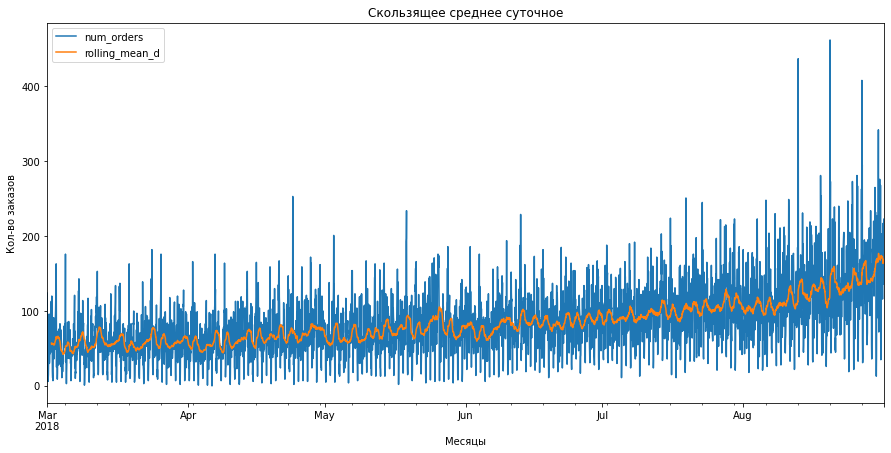

In [9]:
# снизим колебания во временном ряду, применив сколбзящее среднее
df['rolling_mean_d'] = df['num_orders'].rolling(24).mean()
df.plot(figsize=(15,7))
plt.title('Скользящее среднее суточное')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

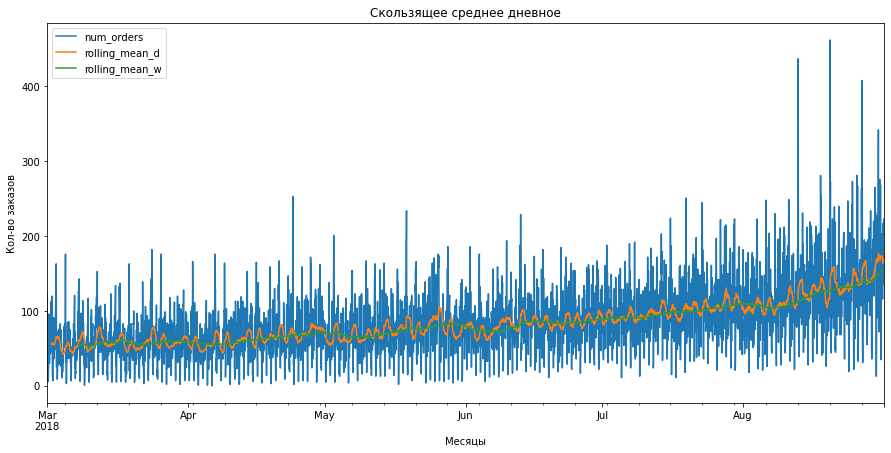

In [10]:
# снизим колебания во временном ряду, применив сколбзящее среднее недельное
df['rolling_mean_w'] = df['num_orders'].rolling(24*7).mean()
df.plot(figsize=(15,7))
plt.title('Скользящее среднее дневное')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Наблюдается возрастающий тренд по количеству заказов. Небольшие спады должно быть наблюдаются в ночное время. Недельное скользящее среднее показывает нам плавно восходящий тренд.

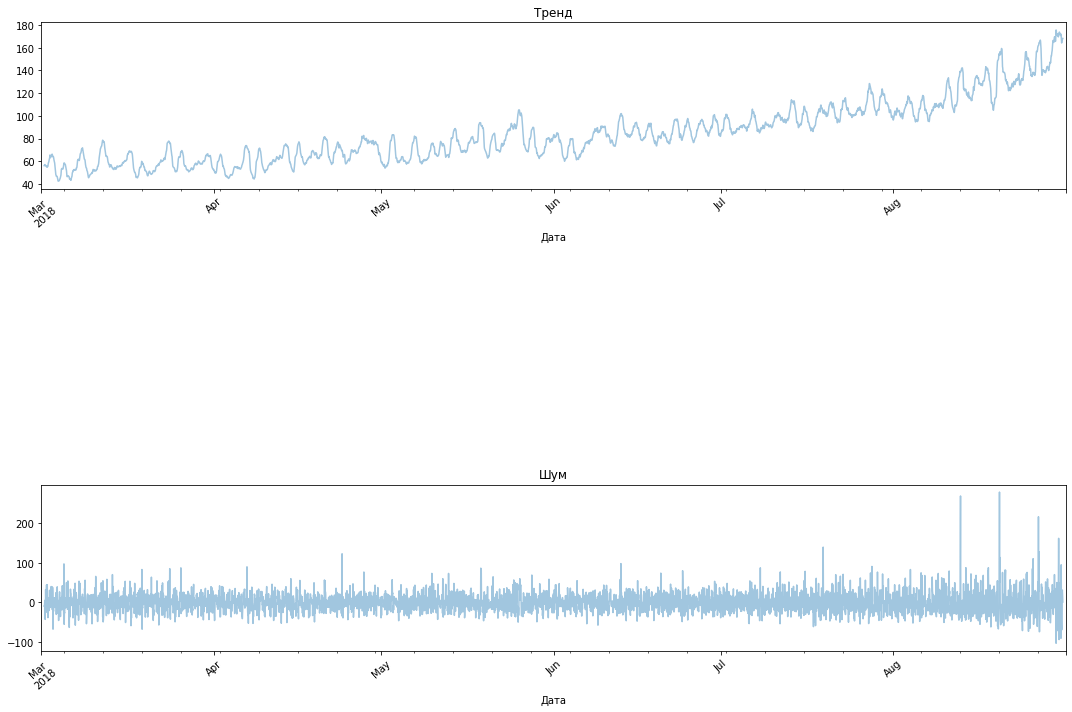

In [11]:
# разложим временной ряд на тренд, сезоннсоть и шум
decomposed = seasonal_decompose(df[['num_orders']])
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), alpha=.42)
plt.title('Тренд')
plt.xticks(rotation=42)
plt.xlabel('Дата')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), alpha=.42) 
plt.title('Шум')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.tight_layout()

Тренд восходящий, для удобства посмотрим график сезонной в течении 1 месяца и одного дня.

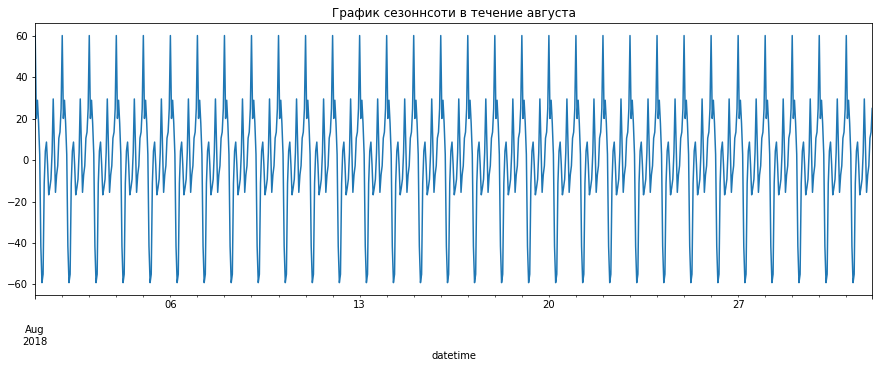

In [12]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(figsize = (15,5));
plt.title('График сезоннсоти в течение августа');

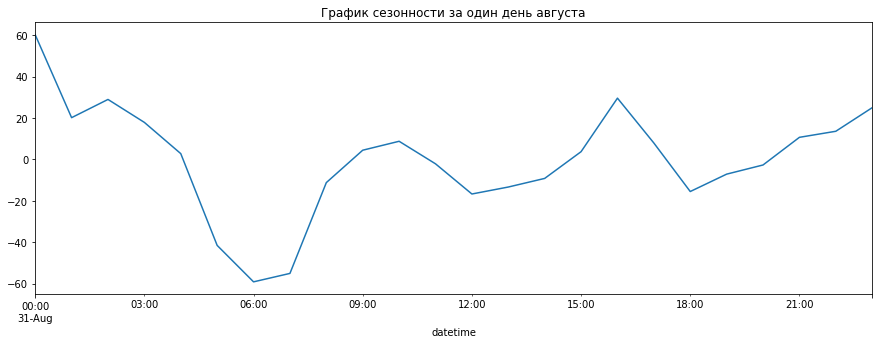

In [13]:
decomposed.seasonal['2018-08-31':'2018-08-31'].plot(figsize = (15,5));
plt.title('График сезонности за один день августа');

Наблюдается постоянная сезоннсоть в течение дня. Максимальное количество вызова такси наблюдается в полночь, в то время когда вызов такси в 6 утра показывают наименьшее количество, далее наблюдается пик в 10 утра и пик побольше между 16-17 часами.

In [14]:
#df_st = df-df.shift()

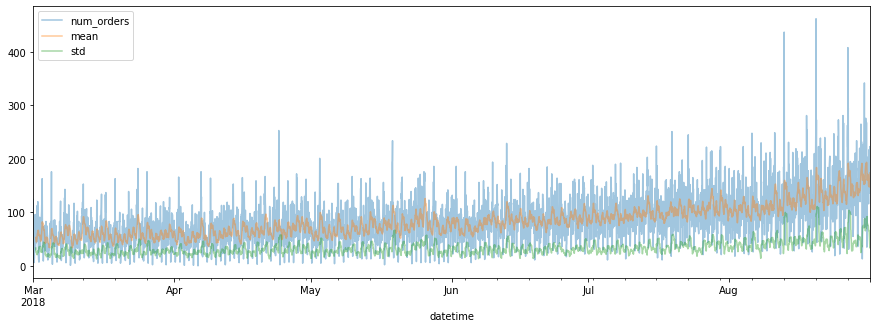

In [15]:
# проверим наш ряд на стационарность
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df[['num_orders', 'mean', 'std']].plot(ax=plt.gca(), alpha=.42, figsize=(15, 5)) 
plt.show()

Наблюдаем незначительный рост стандартного отклонения, его колебания как и незначительный рост среднего. Посмотрим разницу ряда

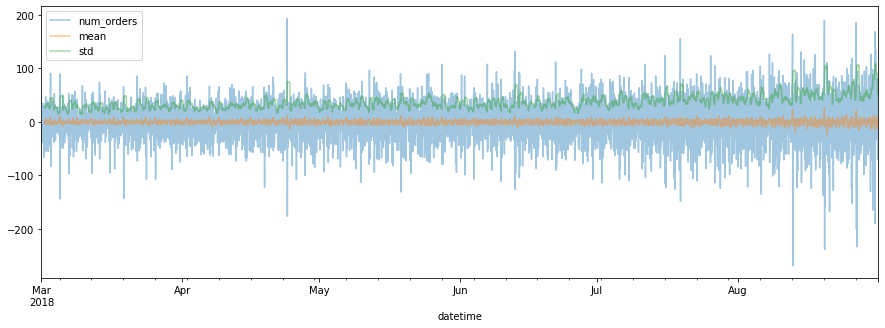

In [16]:
df_shift = df.copy()
plt.figure(figsize=(15, 5))
df_shift['num_orders'] = df_shift - df_shift.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['std'] = df_shift['num_orders'].rolling(15).std()
df_shift[['num_orders', 'mean', 'std']].plot(ax=plt.gca(), alpha=.42) 
plt.show()

Ряд стал более стационарным, удалим вспомогательные признаки, пустые значения для дальнейшего обучения и построения модели.

In [17]:
df = df[['num_orders']]
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проведем статистический тест Дики-Фуллера для проверки стационарности ряда. Выдвигаем гипотезы:

H0 : Временной ряд является нестационарным.

H1 : временной ряд является стационарным.

In [18]:

test = adfuller(df['num_orders'])
print('Статистика теста: ', test[0])
print('p-value: ', test[1])
print('Доверительные интервалы: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Гипотеза Н0 не может быть отвергнута, ряд является нестационарным')
else:
    print ('Гипотеза Н0 отвергнута, ряд является стационарным')

Статистика теста:  -3.0689242890279558
p-value:  0.028940051402612906
Доверительные интервалы:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Гипотеза Н0 отвергнута, ряд является стационарным


Промежуточный вывод: значение t-статистики -3,06 больше значений на 5% и 10% доверительных интервалах, то есть гипотеза, что ряд стационарный, не может быть отвергнута

## Обучение

In [19]:
# создаем разбивку
#folds = KFold(n_splits=4,  shuffle=True, random_state=12354) 

In [20]:
# функция признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [21]:
# применим функцию с лагом до 24 часов и 100-м скользящим средним:
make_features(df, 24, 100)

In [22]:
# удалим пустые значения
df = df.dropna()
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [23]:
#  делим на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle = False, test_size=.1)
train = train.dropna()

In [24]:
# проверка
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-05 04:00:00 2018-08-13 23:00:00
2018-08-14 00:00:00 2018-08-31 23:00:00


In [25]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

#model = LinearRegression()
#model.fit(features_train, target_train)
#train_pred = model.predict(features_train)
#test_pred = model.predict(features_test)

### Линейная регрессия

Так как мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [26]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
model_lr = LinearRegression()

cv_RMSE_LR = (cross_val_score(model_lr, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
model_lr.fit(features_train,target_train)
rmse_lr = round(np.mean(cv_RMSE_LR), 2)
print('RMSE модели линейной регрессии на кросс-валидации:', rmse_lr)

RMSE модели линейной регрессии на кросс-валидации: 27.37
CPU times: user 379 ms, sys: 641 ms, total: 1.02 s
Wall time: 1.02 s


### Случайный лес

In [27]:
%%time
# подсчет лучших гиперпараметров
model_rf = RandomForestRegressor() 

hyperparams = [{ 
                'max_depth': [x for x in range(2, 15)],
                'n_estimators': [x for x in range(0, 150, 50)],
                'random_state':[12345],
                'n_jobs' : [-1]
}]

grid_rf = GridSearchCV(model_rf, hyperparams, scoring='neg_mean_squared_error', cv=tscv)
grid_rf.fit(features_train, target_train)
rmse_rf = abs(grid_rf.best_score_)**0.5
print(grid_rf.best_params_)
print('RMSE модели случайного леса на кросс-валидации: ', rmse_rf)


{'max_depth': 14, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 12345}
RMSE модели случайного леса на кросс-валидации:  25.476568746252745
CPU times: user 2min 24s, sys: 521 ms, total: 2min 24s
Wall time: 2min 25s


### Модель CatBoost

In [28]:
# подсчет лучших гиперпараметров

model_cb = CatBoostRegressor()
params = {'n_estimators' : [50, 100, 150],
          'verbose' : [0],
          'random_state' : [12345],
          'max_depth' : [5, 10, 12]}
grid_cv_cb = GridSearchCV(estimator=model_cb, 
                           param_grid=params, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error', 
                           cv=tscv)
grid_cv_cb.fit(features_train, target_train, verbose=20)
rmse_cat = abs(grid_cv_cb.best_score_) ** 0.5
print(grid_cv_cb.best_params_)
print('RMSE модели CatBoost на кросс-валидации: ', rmse_cat)

Learning rate set to 0.436769
0:	learn: 24.1971547	total: 49.2ms	remaining: 2.41s
20:	learn: 12.3645467	total: 90.1ms	remaining: 124ms
40:	learn: 8.3257770	total: 129ms	remaining: 28.4ms
49:	learn: 7.4625865	total: 146ms	remaining: 0us
Learning rate set to 0.487201
0:	learn: 25.9447892	total: 2.99ms	remaining: 147ms
20:	learn: 15.6120442	total: 48.8ms	remaining: 67.4ms
40:	learn: 12.4299374	total: 102ms	remaining: 22.4ms
49:	learn: 11.5113183	total: 128ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.9656410	total: 5.15ms	remaining: 252ms
20:	learn: 16.8862376	total: 73.9ms	remaining: 102ms
40:	learn: 14.0183120	total: 152ms	remaining: 33.4ms
49:	learn: 12.7606793	total: 176ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.3317394	total: 3.53ms	remaining: 173ms
20:	learn: 17.7440196	total: 74.8ms	remaining: 103ms
40:	learn: 14.8323393	total: 150ms	remaining: 32.8ms
49:	learn: 13.9120304	total: 177ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.3523463	total: 3.93ms

In [34]:
cv_tabl = pd.DataFrame(index=['RMSE на кросс-валидации','Лучшие гиперпараметры'], columns=['LinearRegression','RandomForestRegressor', 'CatBoostRegressor'])
column = ['RMSE на кросс-валидации','Лучшие гиперпараметры']
cv_tabl['LinearRegression'] = rmse_lr, '-'
cv_tabl['RandomForestRegressor'] = rmse_rf, grid_rf.best_params_
cv_tabl['CatBoostRegressor'] = rmse_cat, grid_cv_cb.best_params_


cv_tabl.T.style 

,RMSE на кросс-валидации,Лучшие гиперпараметры
LinearRegression,27.370000,-
RandomForestRegressor,25.476569,"{'max_depth': 14, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 12345}"
CatBoostRegressor,25.188956,"{'max_depth': 5, 'n_estimators': 150, 'random_state': 12345, 'verbose': 0}"


Таким образом, наилучшее качество модели на этапе обучения показала модель CatBoostRegressor, с наилучшими параметрами max_depth = 5, n_estimators = 150, random_state = 12345. Наихудшее качество показала модель линейной регрессии. Тестирование будем проводить на моделе CatBoostRegressor.

## Тестирование

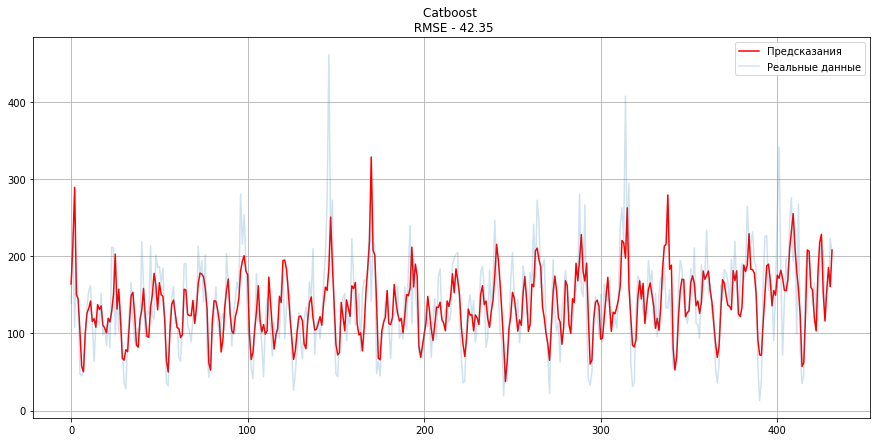

In [44]:
# проводим тестирование наилучшей модели на оптимальных гиперпараметрах
model_cat = CatBoostRegressor(iterations=100, learning_rate=0.25, 
                              verbose=0, random_seed=12345, 
                              max_depth=5)
model_cat.fit(features_train, target_train)
prediction_cat = model_cat.predict(features_test)
rmse_cat_test = mean_squared_error(prediction_cat, target_test)**0.5
plt.figure(figsize=(15, 7))
plt.plot(prediction_lr, "r", label="Предсказания")
plt.plot(target_test.values, label="Реальные данные", alpha=.21)
plt.legend(loc="best")
plt.title("Catboost \n RMSE - {}".format(round(rmse_cat_test, 2)))
plt.grid(True)

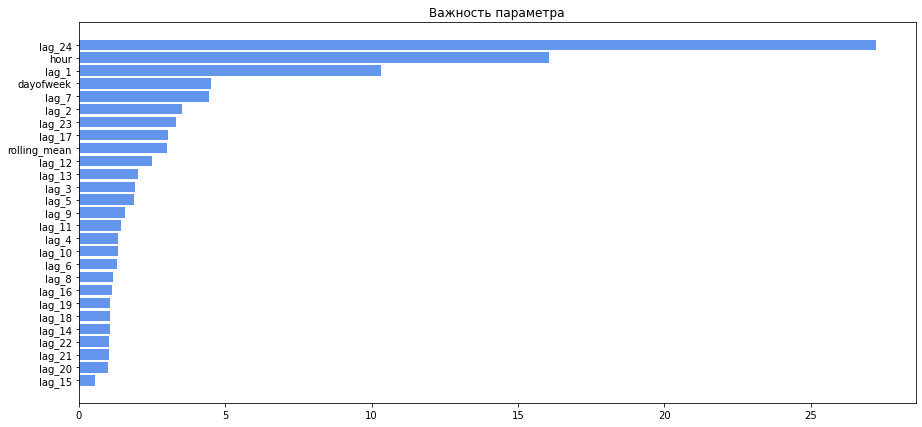

In [42]:
# рассчитаем важность параметров
importances_cat = model_cat.feature_importances_
feat=features_test.columns
indices = np.argsort(importances_cat)
plt.figure(figsize=(15, 7))
plt.title('Важность параметра')
plt.barh(range(len(indices)), importances_cat[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), feat[indices])
plt.show()

Модель CatBoostRegressor на тестовой выборке показывает RMSE равное 42.35, что соответствует условию задания.

## Общий вывод

При выполнении проекта проделана следующая работа:

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.
За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

На втором этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополненном датасете подобраны оптимальные гиперпараметры для моделей линейной регрессии, случайного леса и CatBost, а также модели были обучены на оптимальных гиперпараметров.

Далее было проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель RMSE в данном случае у CatBoostRegressor = 42,35.
